In [34]:
'''Imports'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
from sklearn.cluster import KMeans
from scipy import stats

In [35]:
'''Lets start by opening up the data and cleaning it up'''
data = pd.read_csv('Copy of 2020-XTern-DS - 2020-XTern-DS.csv')
'''Lets change strings and monetary values into floats for computation'''
data = data.replace('-', np.nan)
data = data.replace('Opening Soon', np.nan)
data = data.replace('NEW', np.nan)
data['Rating'] = pd.to_numeric(data['Rating'], 'float')
data['Reviews'] = pd.to_numeric(data['Reviews'], 'float')
data['Votes'] = pd.to_numeric(data['Votes'], 'float')
data['Average_Cost'] = data['Average_Cost'].replace('[\$,]','',regex=True).astype(float) 
data['Minimum_Order'] = data['Minimum_Order'].replace('[\$,]','',regex=True).astype(float)
data['Cook_Time'] = [int(re.sub("[^\d\.]", "", i)) for i in data['Cook_Time']]
'''And given that this is geographic data lets add in city locations as well
    thanks to https://simplemaps.com/data/us-cities for these'''
Cdata = pd.read_csv('uscities.csv')
Cdata = Cdata[Cdata['state_name']=='Indiana']
Cdata = Cdata[Cdata['lat'].between(data['Latitude'].min(),data['Latitude'].max())]
Cdata = Cdata[Cdata['lng'].between(data['Longitude'].min(),data['Longitude'].max())]

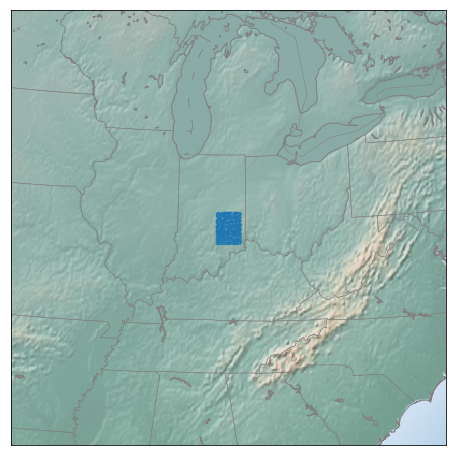

In [36]:
'''Lets take a better look by visualizing it on a map'''
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=data['Latitude'].mean(), lon_0=data['Longitude'].mean(),
            width=1.5E6, height=1.5E6)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

m.scatter(list(data['Longitude']), list(data['Latitude']), latlon=True
          , s=0.1
          )

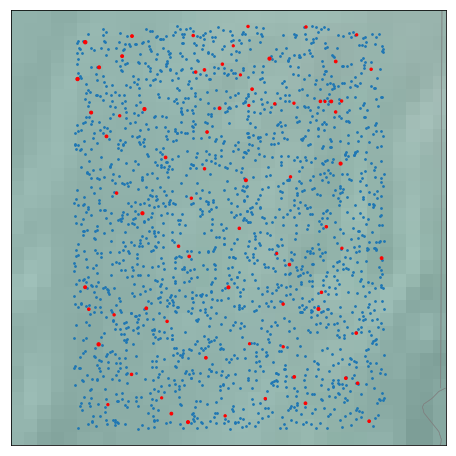

In [37]:
'''Great! We are operating in SE Indiana in a remarably rectangular region.
    Lets take a closer look and get an idea of the distribution.  While we
    are ther we may as well plot the cities.'''
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=data['Latitude'].mean(), lon_0=data['Longitude'].mean(),
            width=1.2E5, height=1.2E5)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

m.scatter(list(data['Longitude']), list(data['Latitude']), latlon=True
          , s=3
          )
m.scatter(list(Cdata['lng']), list(Cdata['lat']), latlon=True
          , s=list(np.log(Cdata['population'])), c='red'
          )
plt.show()
plt.close()

C:\Users\user\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\user\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


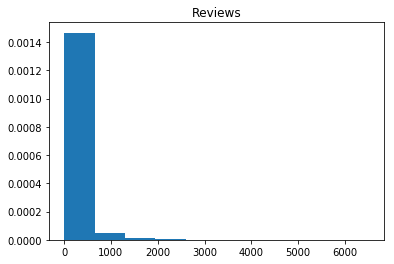

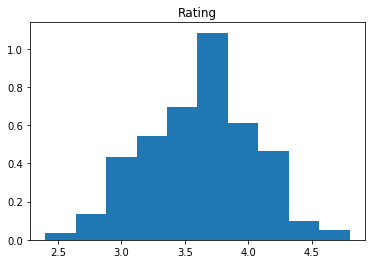

In [38]:
'''The distribution of restraunts does not appear to be uniform noise, if it is a noise based distribution
    I belive it resembles peltier noise with its more topographical appearance'''
'''Upon visual comparison there dosen't seem to be a corrolation between cities and restraunts with some cities being
    in restraunt dead zones.  This can be proven via a two sided KS test a procedure 
    I have utlized in python for astronmy before.  
    However I cannot get Jupyter Notebook to cooperate with those calculations.  
    Due to the likelyhood of multiple clusters this test cannot be simplified to individual x and y KS test.'''
'''Instead of using cities we will try to find the best 'Waiting' points for our drivers.
    To minimize driving we will have drives wait to pick up large batches of food and deliver them in one trip.
    These pick up points will take into account a weight determined by the number of reviews and the rating'''
plt.hist(list(data['Reviews']), density = True)
plt.title('Reviews')
plt.show()
plt.close()
plt.hist(list(data['Rating']), density = True)
plt.title('Rating')
plt.show()
plt.close()

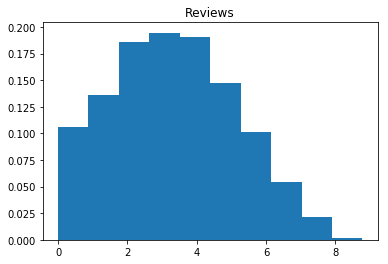

In [39]:
'''Since this is a comparitive metric we are framing these as density histograms.
    While Ratings is fairly well distributed Reviews is hevily skewed.  To rectify this a log scale is applied.'''
plt.hist(list(np.log(data['Reviews'])), density = True)
plt.title('Reviews')
plt.show()
plt.close()

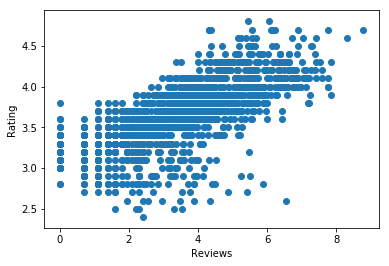

In [40]:
'''Thats much better.  Further comparing the two metrics there is a reasonable positive corolation.
    Generally speaking the more reviews a restraunt has the higher the average rating is.
    This seems like a much more positive rating system thatn Yelp but that is just an educated guess.
    In my experience people are more motivated to leave negitive reviews than positive.'''
plt.scatter(np.log(list(data['Reviews'])), list(data['Rating']))
plt.xlabel('Reviews')
plt.ylabel('Rating')
plt.show()
plt.close()

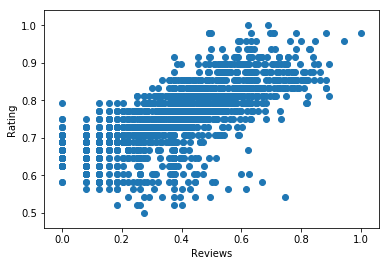

In [41]:
'''To balance out final weight we will normalize each axis, this sets up a similar system to the US legeslative branch.
    One side indicates how many people frequent there, the other represents quality.  We will represent them equally'''
revmed = np.median(np.array(data['Reviews'])[~np.isnan(list(data['Reviews']))])
ratmed = np.median(np.array(data['Rating'])[~np.isnan(list(data['Rating']))])
data['Reviews'] = data['Reviews'].fillna(revmed)
data['Rating'] = data['Rating'].fillna(ratmed)
nrev = np.log(list(data['Reviews']))
normrev = [i/max(nrev) for i in nrev]
nrat = list(data['Rating'])
normrat = [i/max(nrat) for i in nrat]
plt.scatter(normrev, normrat)
plt.xlabel('Reviews')
plt.ylabel('Rating')
plt.show()
plt.close()
Weight = np.add(normrev, normrat)
data['Weight'] = [(i > 0) * i for i in Weight]

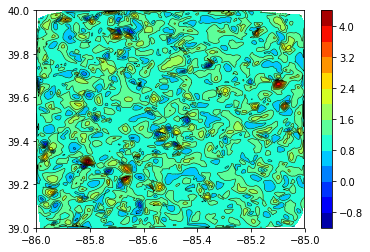

In [42]:
'''Next we will use the weights and the geographic location to construct and interpolate a 'demand' map'''
xi = np.linspace(np.amin(data['Longitude']),np.amax(data['Longitude']),1000)
yi = np.linspace(np.amin(data['Latitude']),np.amax(data['Latitude']),1000)
zi = griddata((data['Longitude'], data['Latitude']), data['Weight'], (xi[None,:], yi[:,None]), method = 'cubic')
plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
plt.colorbar()

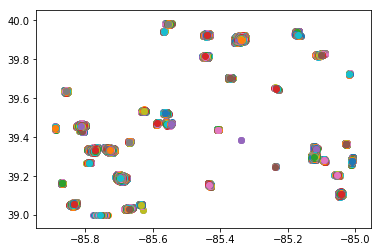

In [43]:
'''Using the interpolated topology and running fine peak detection'''
TopAreas = np.sort(np.nan_to_num(zi).flatten())[-10000:]
NNi = []
for i in TopAreas:
    NN = np.where(zi==i)
    plt.scatter(xi[NN[0]][0], yi[NN[1]][0])
    NNi += [[xi[NN[0]][0], yi[NN[1]][0]]]

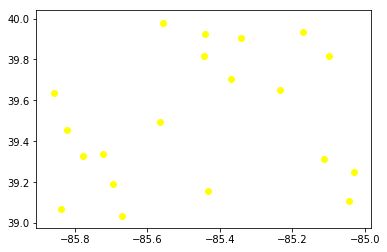

In [44]:
'''Finally using the fine peak and KMean clustering to find the 20 best 'waiting' spots'''
kmeans = KMeans(n_clusters=20, random_state=0).fit(NNi)
centers = kmeans.cluster_centers_
for i in centers:
    plt.scatter(i[0], i [1], c = 'yellow')
plt.show()
plt.close()

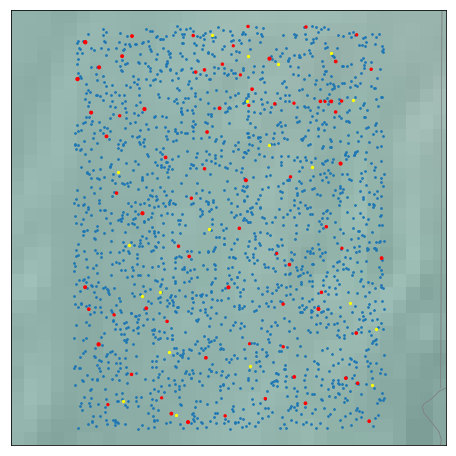

In [45]:
'''Finally let's update out map!'''
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=data['Latitude'].mean(), lon_0=data['Longitude'].mean(),
            width=1.2E5, height=1.2E5)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

m.scatter(list(data['Longitude']), list(data['Latitude']), latlon=True
          , s=3
          )
m.scatter(list(Cdata['lng']), list(Cdata['lat']), latlon=True
          , s=list(np.log(Cdata['population'])), c='red'
          )
for i in centers:
    m.scatter(i[0], i [1], latlon= True
                , c = 'yellow', s = 5
                )

Text(0, 0.5, 'Minimum_Order')

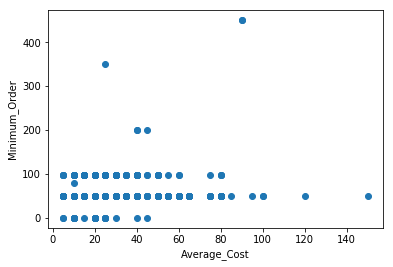

In [46]:
'''As a final striketo the city-restrunt corrolation the most populat points have little to no visual corrolation 
    to the city centers'''
'''Of course pick up points are usless with out orders, and orders won't be made if costs are unreasonable.
    At first glance the Minimum Order seems high on many restraunts.'''
data['Order_Delta'] = data['Average_Cost']-data['Minimum_Order']
plt.scatter(data['Average_Cost'], data['Minimum_Order'])
plt.xlabel('Average_Cost')
plt.ylabel('Minimum_Order')

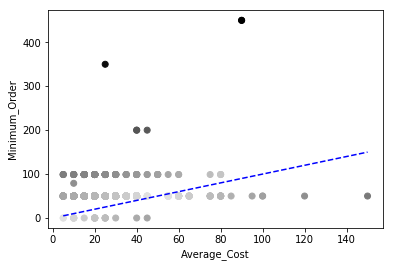

Text(0.5, 0, 'Delta')

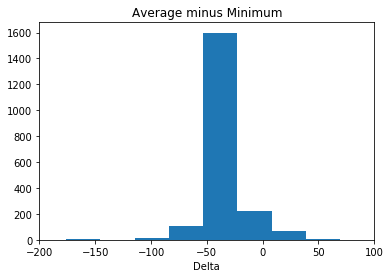

In [50]:
'''That dosen't look remotly 1:1, lets dive deeper.  The blue line represents a 1:1 ratio and 
    the darker the color the higher the discrepency'''
plt.scatter(data['Average_Cost'], data['Minimum_Order'], c = np.sqrt(np.abs(np.subtract(data['Average_Cost'], data['Minimum_Order'])))
            , cmap = 'binary')
plt.ylabel('Minimum_Order')
plt.xlabel('Average_Cost')
plt.plot(np.linspace(data['Average_Cost'].min(), data['Average_Cost'].max(), 100)
         , np.linspace(data['Average_Cost'].min(), data['Average_Cost'].max(), 100), c ='blue', ls = '--')
plt.show()
plt.close()
plt.hist(data['Order_Delta'], bins = 15)
plt.xlim([-200,100])
plt.title('Average minus Minimum')
plt.xlabel('Delta')

In [48]:
'''In the above histogram a negitive value indicates that the minimum order is grater thatn the average order, which 
    should drive down sales.  Just on visual inspection the vast majourity of restraunts have a minimum order that
    ~$50 over the average cost.'''
Nn = len(list(filter(lambda x: (x < 0), data['Order_Delta'])))
Np = len(list(filter(lambda x: (x >= 0), data['Order_Delta'])))
Nz = len(list(filter(lambda x: (x >= 0), data['Order_Delta'])))
Nt = Nn +Np +Nz
print('Percent of Restraunts with a Minimum charge higher than the average cost: ' + str(Nn*100/Nt) + '%')
print('Percent of Restraunts with a Minimum charge equal to the average cost: ' + str(Nz*100/Nt) + '%')
print('Percent of Restraunts with a Minimum charge lower than the average cost: ' + str(Np*100/Nt) + '%')

Percent of Restraunts with a Minimum charge higher than the average cost: 90.20254357041922%
Percent of Restraunts with a Minimum charge equal to the average cost: 4.898728214790391%
Percent of Restraunts with a Minimum charge lower than the average cost: 4.898728214790391%
